# NLP - Unsupervised Learning - 5 Books

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
import nltk

nltk.download('gutenberg')
!python -m spacy download en

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\femis\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
symbolic link created for C:\Users\femis\Anaconda3\lib\site-packages\spacy\data\en <<===>> C:\Users\femis\Anaconda3\lib\site-packages\en_core_web_sm
[+] Linking successful
C:\Users\femis\Anaconda3\lib\site-packages\en_core_web_sm -->
C:\Users\femis\Anaconda3\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


In [142]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


For this modeling we would use Poems by Blake and Stories by Bryant

In [17]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
poems = gutenberg.raw('blake-poems.txt')
stories = gutenberg.raw('bryant-stories.txt')
sense = gutenberg.raw('austen-sense.txt')
busterbrown = gutenberg.raw('burgess-busterbrown.txt')
ball = gutenberg.raw('chesterton-ball.txt')


In [18]:
# The Chapter indicator is idiosyncratic
poems = re.sub(r'Chapter \d+', '', poems)
stories = re.sub(r'CHAPTER .*', '', stories)
sense = re.sub(r'CHAPTER .*', '', sense)
busterbrown = re.sub(r'CHAPTER .*', '', busterbrown)
ball = re.sub(r'CHAPTER .*', '', ball)
    
poems = text_cleaner(poems[:int(len(poems)/10)])
stories = text_cleaner(stories[:int(len(stories)/10)])
sense = text_cleaner(sense[:int(len(sense)/10)])
busterbrown = text_cleaner(busterbrown[:int(len(busterbrown)/10)])
ball = text_cleaner(ball[:int(len(ball)/10)])

In [19]:
print('Cleaned text:\n', poems[0:100])
print('Cleaned text:\n', stories[0:100])
print('Cleaned text:\n', sense[0:100])
print('Cleaned text:\n', busterbrown[0:100])
print('Cleaned text:\n', ball[0:100])

Cleaned text:
 SONGS OF INNOCENCE AND OF EXPERIENCE and THE BOOK of THEL SONGS OF INNOCENCE INTRODUCTION Piping dow
Cleaned text:
 TWO LITTLE RIDDLES IN RHYME There's a garden that I ken, Full of little gentlemen; Little caps of bl
Cleaned text:
 The family of Dashwood had long been settled in Sussex. Their estate was large, and their residence 
Cleaned text:
 I BUSTER BEAR GOES FISHING Buster Bear yawned as he lay on his comfortable bed of leaves and watched
Cleaned text:
 I. A DISCUSSION SOMEWHAT IN THE AIR The flying ship of Professor Lucifer sang through the skies like


In [20]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
poems_doc = nlp(poems)
stories_doc = nlp(stories)
sense_doc = nlp(sense)
busterbrown_doc = nlp(busterbrown)
ball_doc = nlp(ball)

In [22]:
# Group into sentences.
poems_sents = [[sent, "Blake"] for sent in poems_doc.sents]
stories_sents = [[sent, "Bryant"] for sent in stories_doc.sents]
sense_sents = [[sent, "austen"] for sent in sense_doc.sents]
busterbrown_sents = [[sent, "burgess"] for sent in busterbrown_doc.sents]
ball_sents = [[sent, "chesterton"] for sent in ball_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(poems_sents + stories_sents +sense_sents + busterbrown_sents + ball_sents)
sentences.head(10)

,0,1
0,"(SONGS, OF, INNOCENCE, AND, OF, EXPERIENCE, an...",Blake
1,"(INNOCENCE, INTRODUCTION, Piping, down, the, v...",Blake
2,(wild),Blake
3,"(,, Piping, songs, of, pleasant, glee, ,, On, ...",Blake
4,"("", Pipe, a, song, about, a, Lamb, !, "")",Blake
5,"(So, I, piped, with, merry, cheer, .)",Blake
6,"("")",Blake
7,"(Piper, ,, pipe, that, song, again, ;)",Blake
8,"("", So, I, piped, :, he, wept, to, hear, .)",Blake
9,"("")",Blake


### Bag of Words

In [23]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
poemswords = bag_of_words(poems_doc)
storieswords = bag_of_words(stories_doc)
sensewords = bag_of_words(sense_doc)
busterbrownwords = bag_of_words(busterbrown_doc)
ballwords = bag_of_words(ball_doc)

# Combine bags to create a set of unique words.
common_words = set(poemswords + storieswords + sensewords + busterbrownwords + ballwords)

In [24]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450
Processing row 500
Processing row 550
Processing row 600
Processing row 650
Processing row 700
Processing row 750
Processing row 800
Processing row 850
Processing row 900
Processing row 950
Processing row 1000
Processing row 1050
Processing row 1100
Processing row 1150
Processing row 1200
Processing row 1250
Processing row 1300
Processing row 1350
Processing row 1400
Processing row 1450
Processing row 1500
Processing row 1550
Processing row 1600
Processing row 1650
Processing row 1700


,annuity,interminable,clearly,bush,sour,feverish,coincidence,spring,inconvenient,humane,...,ape,insinuation,devolve,answer,advisable,parish,ready,crisis,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(SONGS, OF, INNOCENCE, AND, OF, EXPERIENCE, an...",Blake
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(INNOCENCE, INTRODUCTION, Piping, down, the, v...",Blake
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(wild),Blake
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(,, Piping, songs, of, pleasant, glee, ,, On, ...",Blake
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"("", Pipe, a, song, about, a, Lamb, !, "")",Blake


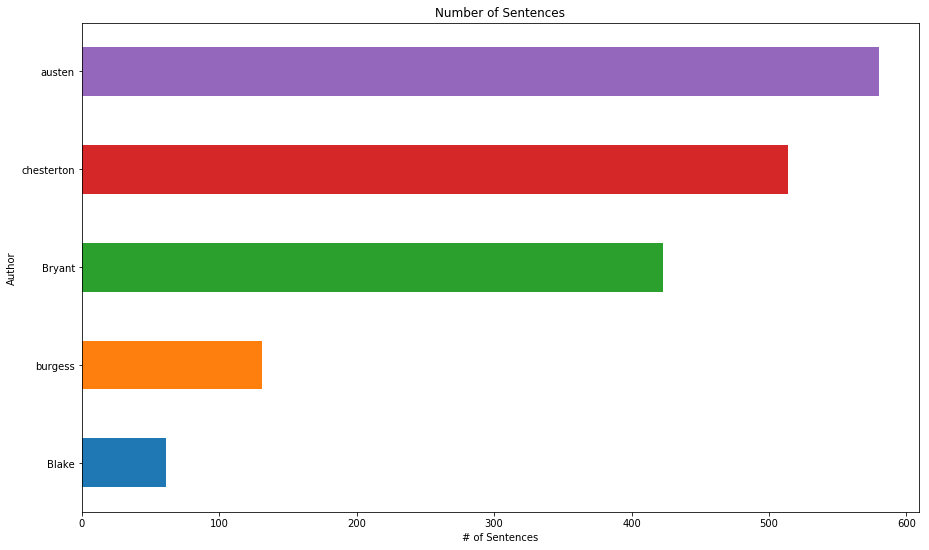

In [38]:
word_counts['text_source'].value_counts().head(15).sort_values().plot(kind='barh', figsize=(15,9))
plt.title('Number of Sentences')
plt.ylabel('Author')
plt.xlabel('# of Sentences')
plt.show()

## BoW
Now let's give the bag of words features a whirl by trying a random forest.

### Random Forest

In [54]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.25,
                                                    random_state=0)

In [55]:
rfc = ensemble.RandomForestClassifier()

train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\femis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.8860265417642467

Test set score: 0.6495327102803738


###  Logistic Regression
Based on the scores you can tell there is some overfitting going on.
Lets try using Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2') # No need to specify l2 as it's the default.
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\femis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\femis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(1281, 3012) (1281,)
Training set score: 0.8477751756440282

Test set score: 0.7009345794392523


Still getting the same results as the Random forest. Still overfitting.

### Lets try with Gradient Boosting

In [53]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.8071818891491023

Test set score: 0.6518691588785047


Results seems a little better. nonetheless still overfitting



## Term Frequency Inverse Document Frequency

In [58]:
#reading in the data, this time in the form of paragraphs

poems_ = gutenberg.paras('blake-poems.txt')
stories_ = gutenberg.paras('bryant-stories.txt')
sense_ = gutenberg.raw('austen-sense.txt')
busterbrown_ = gutenberg.raw('burgess-busterbrown.txt')
ball_ = gutenberg.raw('chesterton-ball.txt')


In [59]:
# Combine the paragraphs from the two novels into one.
books = (poems_ + stories_ + sense_ + busterbrown_ + ball_)
books

[[['[', 'Poems', 'by', 'William', 'Blake', '1789', ']']], [['SONGS', 'OF', 'INNOCENCE', 'AND', 'OF', 'EXPERIENCE', 'and', 'THE', 'BOOK', 'of', 'THEL']], ...]

In [60]:
#processing
books_paras=[]     
for paragraph in books:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    books_paras.append(' '.join(para))

print(books_paras[0:4])


['[ Poems by William Blake 1789 ]', 'SONGS OF INNOCENCE AND OF EXPERIENCE and THE BOOK of THEL', 'SONGS OF INNOCENCE', 'INTRODUCTION']


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(books_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
books_paras_tfidf=vectorizer.fit_transform(books_paras)
print("Number of features: %d" % books_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(books_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1419
Original sentence: i
Tf_idf vector: {}


We now have the vectors, with one vector per paragraph. Lets do some dimension reduction. We'll use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity)

In [62]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])



Percent variance captured by all components: 53.118042397105
Component 0:
" That gives me no idea at all ," said the little Jackal .                                                                                              0.771450
THE LITTLE COTYLEDONS                                                                                                                                   0.730319
" It is too little , too little ."                                                                                                                      0.730319
" Now , let us understand the situation ," said the little Jackal .                                                                                     0.725460
" Yes ," said the little Jackal .                                                                                                                       0.716924
" Oh , I do beg your pardon ," said the little Jackal .                                                                  

From gazing at the most representative sample paragraphs, it appears that component 0 targets dialogue around the description 'little', component 1 seems to largely involve dialogue about what was said, component 2 is center around the word Run, component 3 involve dialogue about the character Brahmin , and component 4 involves referencing people as 'dear'.